In [1]:
from pathlib import Path
from datetime import datetime
from os import PathLike
from typing import Union

# data manipulation and analysis
import numpy as np 
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import seaborn as sns
from prettytable import PrettyTable
import plotly.express as px # An interactive graphing library that makes interactive, publication-quality graphs online.
import plotly.graph_objs as go # An interactive graphing library that makes interactive, publication-quality graphs online.

# ML model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
raw_data_dir = '/Users/yashwanthkaruparthi/Developer/energy_demand/research/data/1-raw/weather-toronto'
raw_data_path = Path(raw_data_dir)
compiled_data_dir = '/Users/yashwanthkaruparthi/Developer/energy_demand/research/data/2-compiled/weather-toronto'
compiled_data_path = Path(compiled_data_dir)
imputed_data_dir = '/Users/yashwanthkaruparthi/Developer/energy_demand/research/data/3-imputed/weather-toronto'
imputed_data_path = Path(imputed_data_dir)

#/Users/yashwanthkaruparthi/Developer/energy_demand/research/data/1-raw/weather-toronto

### Compiling raw weather data

In [3]:
def format_weather_file(filepath: Union[str, PathLike]) -> pd.DataFrame:
    """
    Read an hourly weather data report formatted as per an Ministry of environment Weather Station file
    Rename the columns to shorter form
    Remove empty rows by looking for blanks in the Temp column
    Returns ascending date indexed DataFrame
    """
    col_renames = {'Date/Time': 'date', 'Temp (°C)': 'temp', 'Dew Point Temp (°C)':'dew_point_temp',
                   'Rel Hum (%)': 'rel_hum', 'Wind Spd (km/h)': 'wind_speed', 'Visibility (km)': 'visibility',
                   'Stn Press (kPa)': 'press', 'Hmdx': 'hmdx', 'Wind Chill': 'wind_chill', 'Weather': 'weather'}
    keeper_cols = list(col_renames.values())
    
    df = pd.read_csv(filepath, sep=',', parse_dates=['Date/Time'], skiprows=15)
    df.rename(columns=col_renames, inplace=True)
    df = df[keeper_cols]
    df.set_index('date', inplace=True, drop=True)
    df.dropna(subset =['temp'], inplace=True)
    df.sort_index(inplace=True)

    return df

In [4]:
# Get the raw directory filepaths
csv_fps = [fp for fp in raw_data_path.iterdir() if fp.is_file()]
# create multiple dfs from each filepath
dfs = [format_weather_file(fp) for fp in csv_fps]
# combine into a single DataFrame and save in the interim dir
weather_df = pd.concat(dfs, axis=0)
# We need to drop duplicate index values due to the overlap in the weather data
weather_df = weather_df.loc[~weather_df.index.duplicated()]
weather_df.sort_index(inplace=True)
weather_df.to_csv(compiled_data_path / "weather_toronto.csv")

Data review

In [9]:
dtypes = {'temp': np.float64, 'dew_point_temp':np.float64, 'rel_hum':np.float64,
          'wind_speed': np.float64, 'visibility': np.float64, 'press': np.float64,
          'hmdx': np.float64, 'wind_chill': np.float64, 'weather': object}

weather_df = pd.read_csv(compiled_data_path / "weather_toronto.csv", parse_dates=['date'],
                 dtype=dtypes, index_col=0, infer_datetime_format=True)

weather_df.head()

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_6374/1206830842.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  weather_df = pd.read_csv(compiled_data_path / "weather_toronto.csv", parse_dates=['date'],


,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather
date,,,,,,,,,
1953-01-01 00:00:00,-5.6,-6.7,93.0,10.0,25.0,99.44,NaN,-10.0,Cloudy
1953-01-01 01:00:00,-5.6,-9.4,71.0,3.0,25.0,99.46,NaN,-7.0,Cloudy
1953-01-01 02:00:00,-5.0,-8.9,72.0,0.0,19.3,99.43,NaN,NaN,Cloudy
1953-01-01 03:00:00,-5.0,-7.8,79.0,0.0,19.3,99.56,NaN,NaN,Cloudy
1953-01-01 04:00:00,-4.4,-7.2,80.0,0.0,19.3,99.55,NaN,NaN,Cloudy


In [5]:
weather_df.shape

(582248, 9)

In [10]:
weather_df.tail()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather
date,,,,,,,,,
2019-06-11 19:00:00,19.4,2.5,32.0,16.0,24.1,99.88,NaN,NaN,Clear
2019-06-11 20:00:00,18.0,1.8,33.0,9.0,24.1,99.89,NaN,NaN,NaN
2019-06-11 21:00:00,17.0,2.7,38.0,13.0,24.1,99.89,NaN,NaN,NaN
2019-06-11 22:00:00,14.7,4.0,48.0,11.0,24.1,99.92,NaN,NaN,Clear
2019-06-11 23:00:00,14.0,4.4,52.0,12.0,24.1,99.94,NaN,NaN,NaN


In [11]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 582248 entries, 1953-01-01 00:00:00 to 2019-06-11 23:00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   temp            582248 non-null  float64
 1   dew_point_temp  582213 non-null  float64
 2   rel_hum         582210 non-null  float64
 3   wind_speed      582245 non-null  float64
 4   visibility      582248 non-null  float64
 5   press           582239 non-null  float64
 6   hmdx            77405 non-null   float64
 7   wind_chill      143782 non-null  float64
 8   weather         552686 non-null  object 
dtypes: float64(8), object(1)
memory usage: 44.4+ MB


In [12]:
print(weather_df.isnull().sum())

temp                   0
dew_point_temp        35
rel_hum               38
wind_speed             3
visibility             0
press                  9
hmdx              504843
wind_chill        438466
weather            29562
dtype: int64


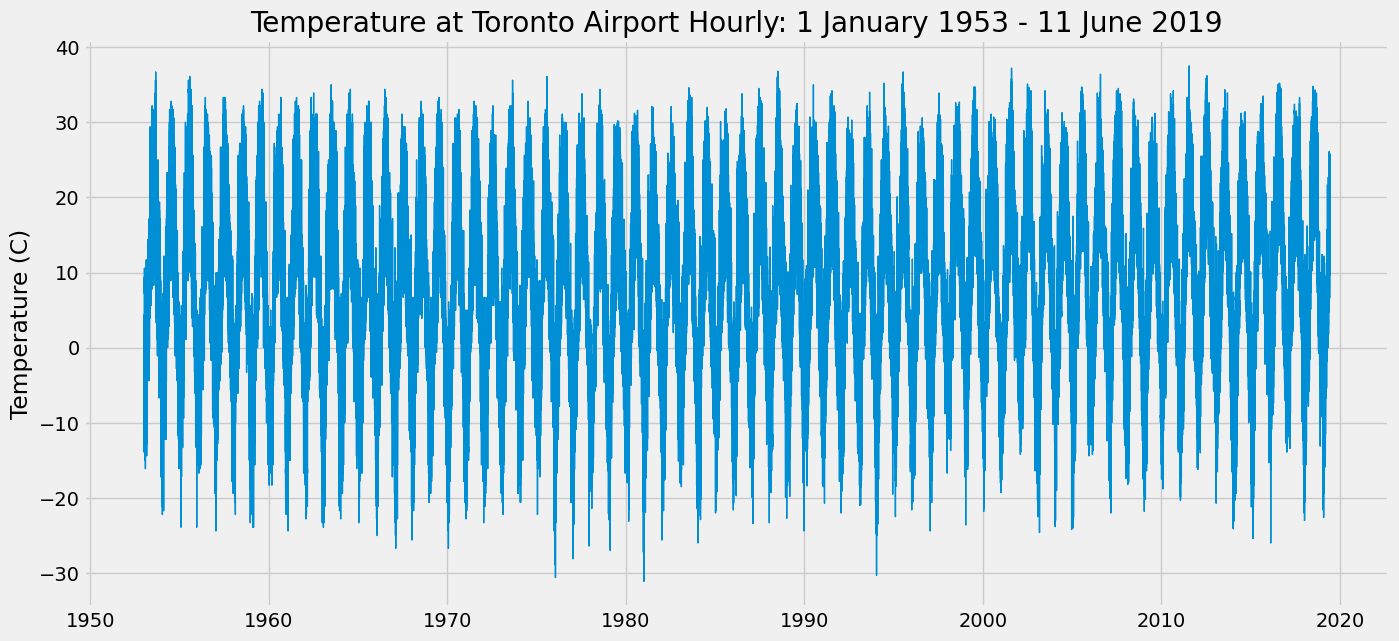

In [23]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(weather_df['temp'], linewidth=1)
ax.set_ylabel('Temperature (C)')
ax.set_title('Temperature at Toronto Airport Hourly: 1 January 1953 - 11 June 2019')
plt.show();

### Verify and clean missing data

In [20]:
# Firstly, make sure the datetime index covers every hour from start to finish  
# create an empty DataFrame that starts at the data start date and ends at the data end date
start = weather_df.index.values[0] ; end = weather_df.index.values[-1] ; freq = '1h'
full_index = pd.date_range(freq=freq, start=start, end=end)
mt_df = pd.DataFrame([np.NaN]* len(full_index), index=full_index)

# Concat this fully indexed mt dataFrame to the data dataFrame with outer join
concat_df = pd.concat([mt_df, weather_df], axis=1,join='outer', sort=True)

# find any places where the temp data is a NaN
gaps = concat_df[concat_df['temp'].isnull()].index.values

print(f'there are {len(gaps)} missing data :_)')

there are 185 missing data :_)


In [21]:
gaps

array(['1953-06-30T04:00:00.000000000', '1953-08-24T19:00:00.000000000',
       '1953-12-12T23:00:00.000000000', '1955-11-28T17:00:00.000000000',
       '1955-11-30T07:00:00.000000000', '1957-06-26T02:00:00.000000000',
       '1957-12-29T06:00:00.000000000', '1983-05-29T17:00:00.000000000',
       '1990-01-23T12:00:00.000000000', '1990-01-23T13:00:00.000000000',
       '1990-01-23T14:00:00.000000000', '1990-01-23T15:00:00.000000000',
       '1990-01-23T16:00:00.000000000', '1994-02-01T00:00:00.000000000',
       '1994-02-01T01:00:00.000000000', '1994-03-27T02:00:00.000000000',
       '1994-05-25T08:00:00.000000000', '1994-07-31T19:00:00.000000000',
       '1994-07-31T20:00:00.000000000', '1994-07-31T21:00:00.000000000',
       '1994-07-31T22:00:00.000000000', '1994-07-31T23:00:00.000000000',
       '1994-08-01T00:00:00.000000000', '1994-08-01T01:00:00.000000000',
       '1995-07-01T03:00:00.000000000', '1995-07-04T06:00:00.000000000',
       '1995-08-02T20:00:00.000000000', '1995-08-02

* 185 missing values out of 582432 possible instances accounts for 0.03% of data missing
* Based on the above dates with missing values, since there are no major consecutive gaps, linear interpolation is used to impute missing values

### Imputation

In [24]:
weather_df = concat_df.copy()
weather_df.drop(columns=[0], inplace=True)
interp_cols = ['temp', 'dew_point_temp', 'rel_hum', 'wind_speed', 'visibility', 'press']
weather_df[interp_cols] = weather_df[interp_cols].interpolate(method='linear', limit_direction='forward', axis=0)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 582433 entries, 1953-01-01 00:00:00 to 2019-06-11 23:00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   temp            582433 non-null  float64
 1   dew_point_temp  582433 non-null  float64
 2   rel_hum         582433 non-null  float64
 3   wind_speed      582433 non-null  float64
 4   visibility      582433 non-null  float64
 5   press           582433 non-null  float64
 6   hmdx            77405 non-null   float64
 7   wind_chill      143782 non-null  float64
 8   weather         552686 non-null  object 
dtypes: float64(8), object(1)
memory usage: 44.4+ MB


In [27]:
# Firstly, make sure the datetime index covers every hour from start to finish  
# create an empty DataFrame that starts at the data start date and ends at the data end date
start = weather_df.index.values[0] ; end = weather_df.index.values[-1] ; freq = '1h'
full_index = pd.date_range(freq=freq, start=start, end=end)
mt_df = pd.DataFrame([np.NaN]* len(full_index), index=full_index)

# Concat this fully indexed mt dataFrame to the data dataFrame with outer join
concat_df = pd.concat([mt_df, weather_df], axis=1,join='outer', sort=True)

# find any places where the temp data is a NaN
gaps = concat_df[concat_df['temp'].isnull()].index.values

print(f'there are {len(gaps)} missing data after imputation:)')

there are 0 missing data after imputation:)


### EDA

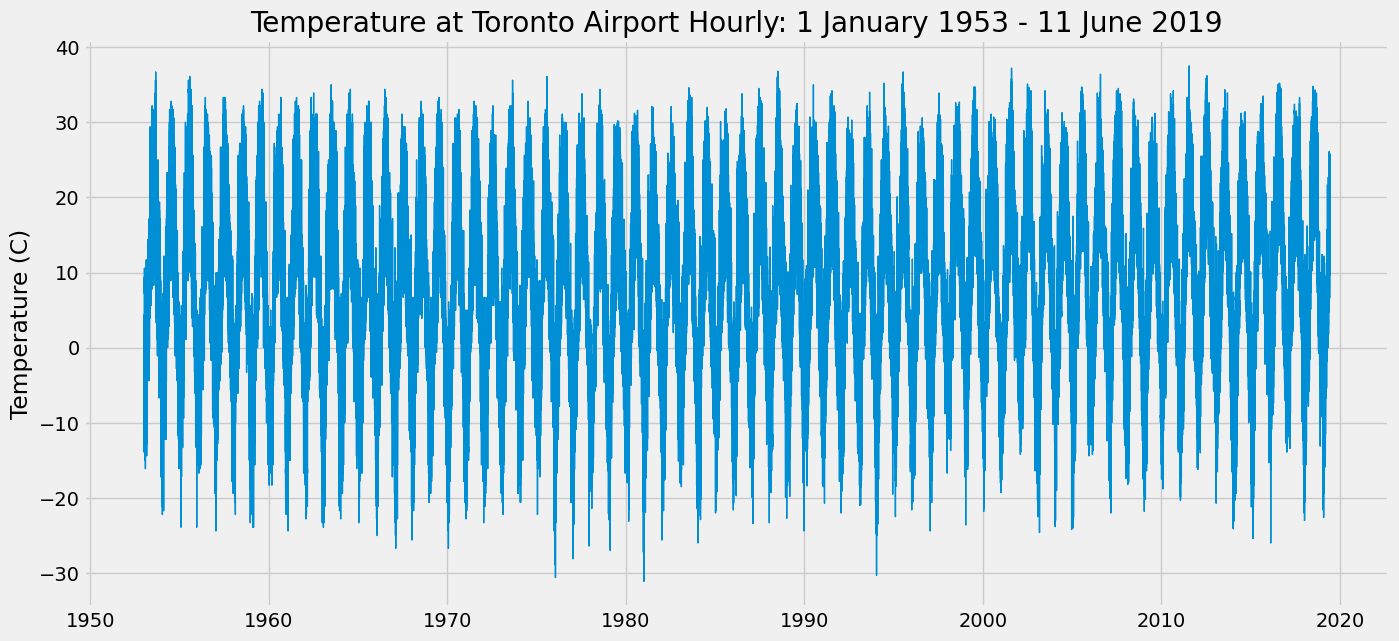

In [28]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(weather_df['temp'], linewidth=1)
ax.set_ylabel('Temperature (C)')
ax.set_title('Temperature at Toronto Airport Hourly: 1 January 1953 - 11 June 2019')
plt.show();

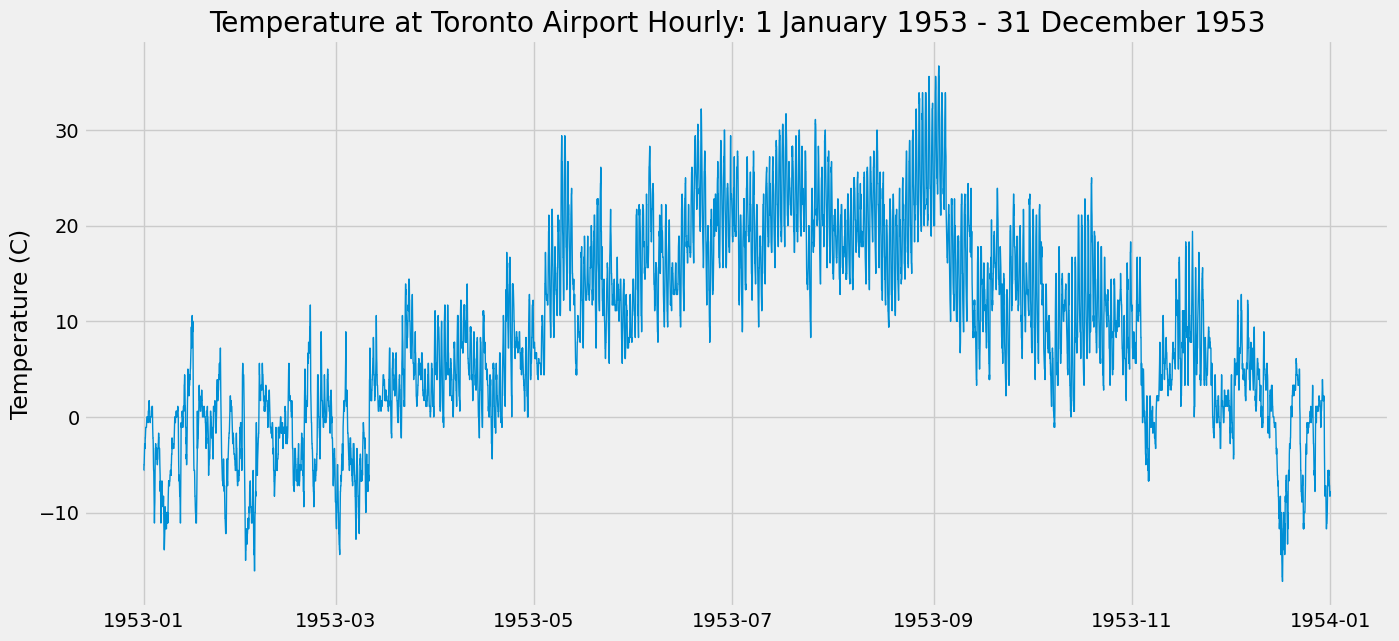

In [30]:
plt.style.use('fivethirtyeight')
# plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(weather_df.loc['1953-01-01':'1953-12-31', 'temp'], linewidth=1)
ax.set_ylabel('Temperature (C)')
ax.set_title('Temperature at Toronto Airport Hourly: 1 January 1953 - 31 December 1953')
plt.show();

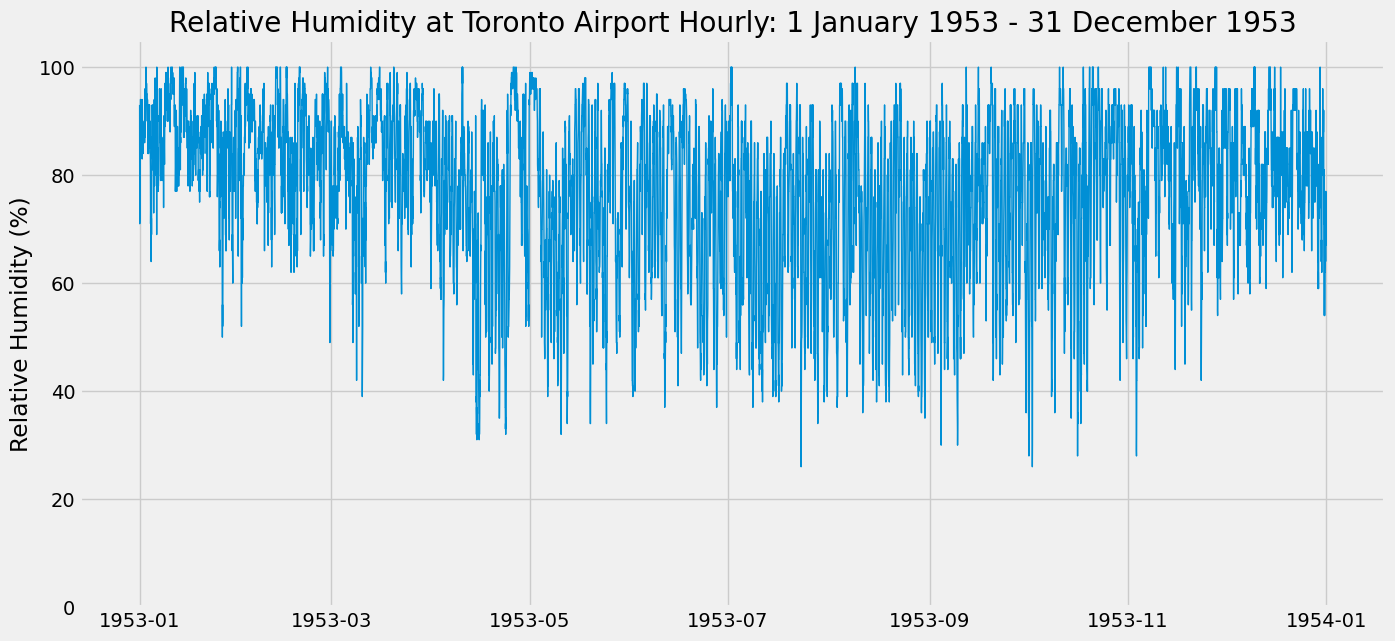

In [31]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(weather_df.loc['1953-01-01':'1953-12-31', 'rel_hum'], linewidth=1)
ax.set_ylabel('Relative Humidity (%)')
ax.set_ylim((0,105))
ax.set_title('Relative Humidity at Toronto Airport Hourly: 1 January 1953 - 31 December 1953')
plt.show();

In [33]:
weather_df.to_csv(imputed_data_path / "weather_toronto.csv")

In [34]:
weather_df.head()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather
1953-01-01 00:00:00,-5.6,-6.7,93.0,10.0,25.0,99.44,NaN,-10.0,Cloudy
1953-01-01 01:00:00,-5.6,-9.4,71.0,3.0,25.0,99.46,NaN,-7.0,Cloudy
1953-01-01 02:00:00,-5.0,-8.9,72.0,0.0,19.3,99.43,NaN,NaN,Cloudy
1953-01-01 03:00:00,-5.0,-7.8,79.0,0.0,19.3,99.56,NaN,NaN,Cloudy
1953-01-01 04:00:00,-4.4,-7.2,80.0,0.0,19.3,99.55,NaN,NaN,Cloudy


In [35]:
weather_df.tail()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather
2019-06-11 19:00:00,19.4,2.5,32.0,16.0,24.1,99.88,NaN,NaN,Clear
2019-06-11 20:00:00,18.0,1.8,33.0,9.0,24.1,99.89,NaN,NaN,NaN
2019-06-11 21:00:00,17.0,2.7,38.0,13.0,24.1,99.89,NaN,NaN,NaN
2019-06-11 22:00:00,14.7,4.0,48.0,11.0,24.1,99.92,NaN,NaN,Clear
2019-06-11 23:00:00,14.0,4.4,52.0,12.0,24.1,99.94,NaN,NaN,NaN


In [37]:
describe = weather_df.describe()
describe_transpose = describe.transpose()
describe_transpose

,count,mean,std,min,25%,50%,75%,max
temp,582433.0,8.038728,11.065744,-31.10,0.00,8.00,17.10,37.50
dew_point_temp,582433.0,2.984651,10.120279,-36.10,-4.10,3.10,11.20,26.60
rel_hum,582433.0,72.808062,16.374186,10.00,62.00,75.00,85.00,100.00
wind_speed,582433.0,15.352870,9.774726,0.00,8.00,13.00,21.00,97.00
visibility,582433.0,20.722932,9.713061,0.00,12.90,24.10,25.00,136.80
press,582433.0,99.495314,0.773273,94.16,99.02,99.52,99.99,102.69
hmdx,77405.0,29.726013,3.779241,25.00,27.00,29.00,32.00,50.00
wind_chill,143782.0,-12.048963,6.497408,-45.00,-16.00,-11.00,-7.00,0.00
